Text(0, 0.5, 'v')

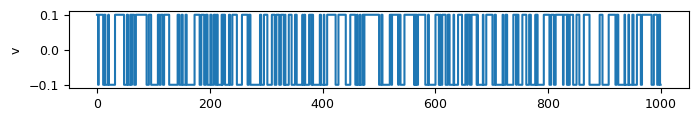

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from joblib import Parallel, delayed
from ssms.basic_simulators.simulator import simulator
from statsmodels.tsa.stattools import acf

from drift_diffusion.model import DriftDiffusionModel, pdf


def adaptive_z(choice_t1, epsilon, a):
    y0 = choice_t1 * np.log(((1 - epsilon) * np.exp(a) + epsilon) / (epsilon * np.exp(a) + (1 - epsilon)))
    return y0 / a


z_to_ssm = lambda z: (z + 1) / 2

rng = np.random.default_rng(seed=0)
n_samples, n_repeats = 1000, 900
epsilon = 0.2
states = np.zeros(n_samples, dtype=int)  # 0=L, 1=R

states[0] = rng.integers(0, 2)
for t in range(1, n_samples):
    if rng.random() < epsilon:
        states[t] = 1 - states[t - 1]  # switch
    else:
        states[t] = states[t - 1]  # repeat

v_0 = 0.1
v = np.where(states == 1, v_0, -v_0)

fig, ax = plt.subplots(figsize=(8, 1))
ax.plot(v[:1000], drawstyle="steps-post")
ax.set_ylabel("v")

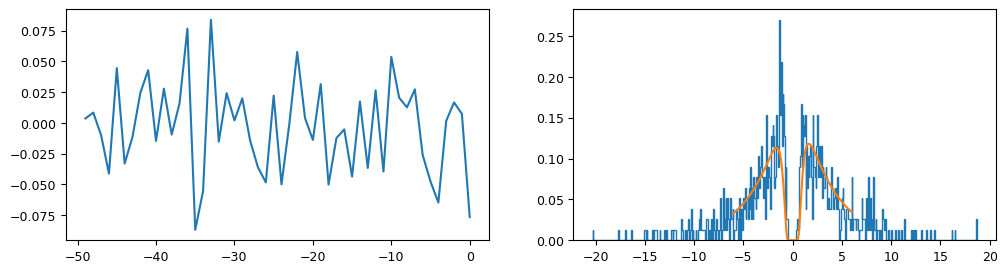

In [2]:
ys = np.zeros((n_samples, n_repeats))
choices = np.zeros((n_samples, n_repeats))
sim_params = {"a": 2, "t": 0.3}
for t in range(n_samples):
    sim_params["v"] = v[t]
    if t == 0:
        sim_params["z"] = np.repeat(0.5, n_repeats)  # neutral start for first trial
    else:
        # previous choice: +1 for right, -1 for left (from boundary crossing)
        prev_choice = choices[t - 1, :]
        # z = adaptive_z(prev_choice, epsilon, sim_params["a"])
        z = 0.3 * -prev_choice
        sim_params["z"] = z_to_ssm(z)
    sims = simulator(model="ddm", theta=sim_params, n_samples=1, smooth_unif=False, random_state=t)
    # record simulated RT and choice
    ys[t, :] = np.squeeze(sims["rts"] * sims["choices"])
    choices[t, :] = np.squeeze(sims["choices"])  # +1 = right, -1 = left

fig, axs = plt.subplots(ncols=2, figsize=(12, 3))

n_lags = 50
axs[0].plot(-np.arange(n_lags), acf(ys[:, 0], nlags=n_lags)[1:])
axs[1].hist(ys[:, 0], bins=500, histtype="step", density=True)

rt_range = (1e-5, 6)
y = np.r_[-np.linspace(*rt_range, 100)[::-1], np.linspace(*rt_range, 100)]
axs[1].plot(y, pdf(y, a=sim_params["a"], t0=sim_params["t"], v=0.01, z=0))

In [3]:
# initlaize ddm
param_names = ["a", "v", "z"]
cov_names = [f"{i},{j}" for i in param_names for j in param_names]
X = pd.DataFrame(np.ones(n_samples))
ddm = DriftDiffusionModel(t0=sim_params["t"], cov_estimator="all")


@delayed
def run_simulation(rep):
    ddm.fit(X, ys[:, rep])
    covs_ = [
        {"estimator": k, **{cov_names[i]: val for i, val in enumerate(utils.cov_to_corr(v).flatten())}}
        for k, v in ddm.covariance_.items()
    ]

    return ddm.params_, covs_


with Parallel(n_jobs=-4) as parallel:
    results = parallel(run_simulation(rep) for rep in range(n_repeats))

params_, covs_ = zip(*results)
params_df = pd.DataFrame(params_, columns=param_names)
covs_df = pd.DataFrame([row for c in covs_ for row in c])

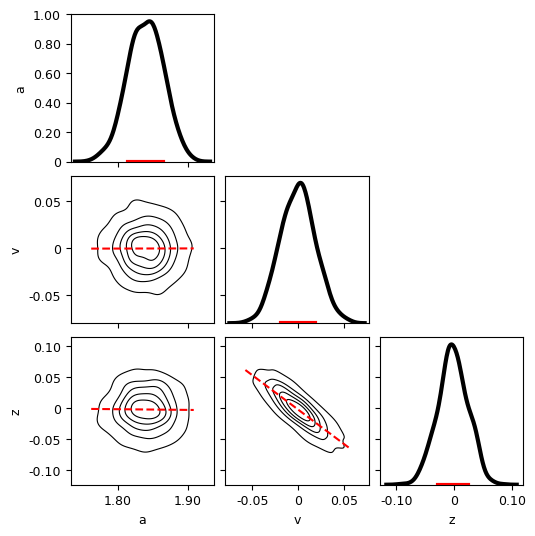

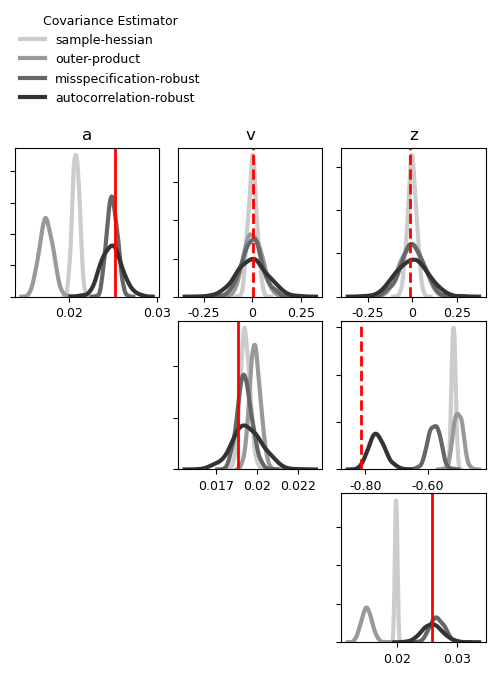

In [4]:
utils.plot_parameter_distributions(params_df, None)
utils.plot_covariance_distributions(covs_df, params_df, param_names)